<a href="https://www.kaggle.com/code/mahyararani/fraudclassification?scriptVersionId=113488022" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<h1 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#241571; background:#B5cae9; border:2px dashed #efe50b;" role="tab" aria-controls="goal"><center></bold>Fraud Classification: An Explotation of Classification Models</center></h1>

![Linear_Regression.jpg](https://www.frbservices.org/binaries/content/gallery/crsocms/news/fed360/070120/fraudclassifier-full.png)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer # Imputing missing values
from imblearn.under_sampling import RandomUnderSampler # Class Imbalance

# Numerical features selection
from sklearn.decomposition import PCA 

# Categorical Features Selection
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

# Classification Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import naive_bayes
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

# Model validation
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

# Model Optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Metrics
from sklearn import metrics

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer
import imblearn.pipeline as imp # imblearn pipeline


# Other General Imports
import gc
%matplotlib inline
import time
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

# Data Loading and Reducing the Size

Since the data is big in size, we will use function to reduce its memory for fast processing and consuming less storage.

In [2]:
# Helper function
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
# loading train_transaction data
tt = pd.read_csv('/kaggle/input/ieeecis-fraud-detection/train_transaction.csv')
print(tt.shape)
tt = reduce_mem_usage(tt)

# loading train_transaction data
ti = pd.read_csv('/kaggle/input/ieeecis-fraud-detection/train_identity.csv')
print(ti.shape)
ti = reduce_mem_usage(ti)

train = pd.merge(tt, ti, how = 'left')
print('Train shape',train.shape)

train.head()

del tt, ti

(590540, 394)
Memory usage of dataframe is 1775.15 MB
Memory usage after optimization is: 487.16 MB
Decreased by 72.6%
(144233, 41)
Memory usage of dataframe is 45.12 MB
Memory usage after optimization is: 10.00 MB
Decreased by 77.8%
Train shape (590540, 434)


In [4]:
# loading test_transaction data
ts = pd.read_csv('/kaggle/input/ieeecis-fraud-detection/test_transaction.csv')
print(ts.shape)
ts = reduce_mem_usage(ts)

tsi = pd.read_csv('/kaggle/input/ieeecis-fraud-detection/test_identity.csv')
print(tsi.shape)
tsi = reduce_mem_usage(tsi)

test = pd.merge(ts, tsi, how = 'left')
print('Test shape',test.shape)
test.head()

del ts, tsi

(506691, 393)
Memory usage of dataframe is 1519.24 MB
Memory usage after optimization is: 425.24 MB
Decreased by 72.0%
(141907, 41)
Memory usage of dataframe is 44.39 MB
Memory usage after optimization is: 9.84 MB
Decreased by 77.8%
Test shape (506691, 433)


# Data Understanding

## Data Exploration

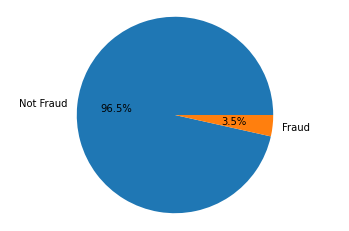

In [5]:
# Class imbalance check
plt.pie(train.isFraud.value_counts(), labels=['Not Fraud', 'Fraud'], autopct='%0.1f%%')
plt.axis('equal')
plt.show()

As one can expect, this is a class imbalance problem. Thus, the accuracy and specifity are not a good criteria to measure the models we want to apply later and we must change the sensitivity in our classification models and change it to 0.35 indstead of 0.5 or apply more novel methods dealing with imbalance dataset. 
We will apply UnderSampling to deal with class imbalance in later steps. Let us understand the distribution of the timestamp column.

### TransactionDT

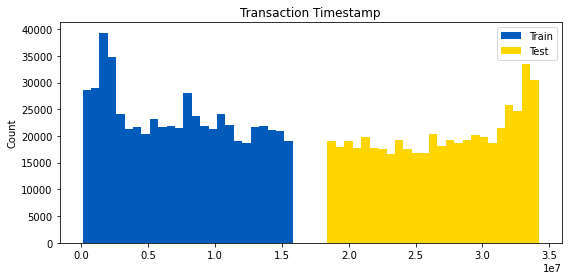

In [6]:
plt.figure(figsize=(8, 4))
plt.hist(train['TransactionDT'], label='Train', bins = 25, color="#005BBB")
plt.hist(test['TransactionDT'], label='Test', bins = 25, color= "#FFD500")
plt.ylabel('Count')
plt.title('Transaction Timestamp')
plt.legend()
plt.tight_layout()
plt.show()

The difference train.min() and test.max() is x = 34214345 - 86400 = 34127945 but we don't know is it in seconds,minutes or hours.

If it is in hours then the dataset timespan will be x/(24*365) = 3895.884132 years which is not possible.

if it is in minutes then the dataset timespan will be x/(60*24*365) = 64.931402 years which is not possible because Vesta Corporation was founded in 1995 so they can have at most 24 years of data.

If it is in seconds then dataset timespan will be x/(3600*24*365) = 1.0821 years which seems reasonable to me.

**Time span of the total dataset is 394.9993634259259 days**

**Time span of Train dataset is  181.99920138888888 days**

**Time span of Test dataset is  182.99908564814814 days**

**The gap between train and test is 30.00107638888889 days**

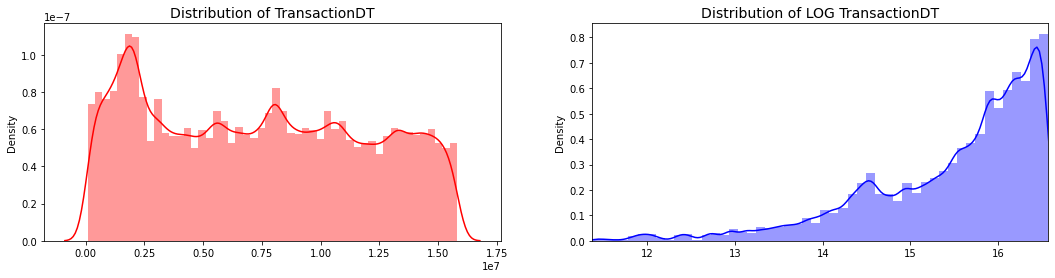

In [7]:

fig, ax = plt.subplots(1, 2, figsize=(18,4))

time_val = train['TransactionDT'].values

sns.distplot(time_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of TransactionDT', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

sns.distplot(np.log(time_val), ax=ax[1], color='b')
ax[1].set_title('Distribution of LOG TransactionDT', fontsize=14)
ax[1].set_xlim([min(np.log(time_val)), max(np.log(time_val))])

plt.show()

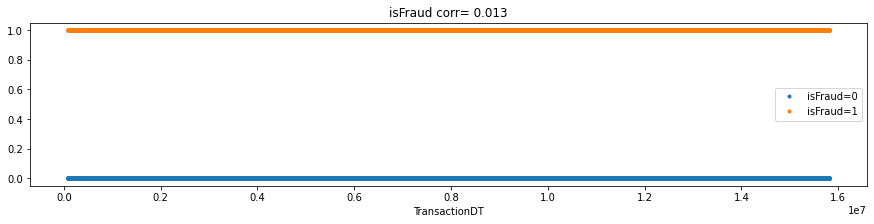

In [8]:
i = 'isFraud'
cor = np.corrcoef(train['TransactionDT'], train[i])[0,1]
train.loc[train['isFraud'] == 0].set_index('TransactionDT')[i].plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3), label="isFraud=0")
train.loc[train['isFraud'] == 1].set_index('TransactionDT')[i].plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3), label="isFraud=1")
#test_transaction.set_index('TransactionDT')[i].plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3))
plt.legend()
plt.show()

### Transation Amount

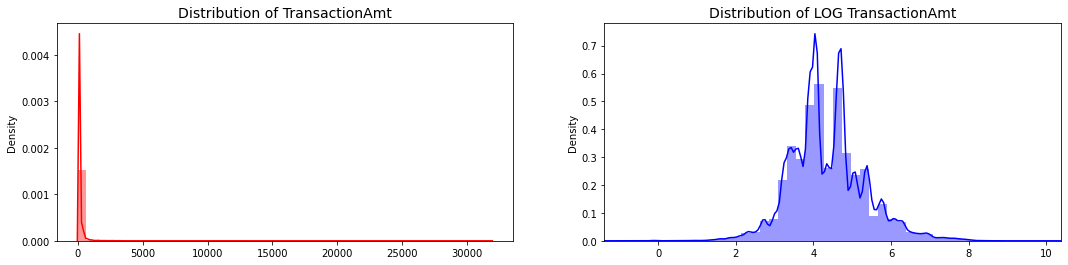

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

time_val = train['TransactionAmt'].values

sns.distplot(time_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of TransactionAmt', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

sns.distplot(np.log(time_val), ax=ax[1], color='b')
ax[1].set_title('Distribution of LOG TransactionAmt', fontsize=14)
ax[1].set_xlim([min(np.log(time_val)), max(np.log(time_val))])

plt.show()

### ProductCD Feature

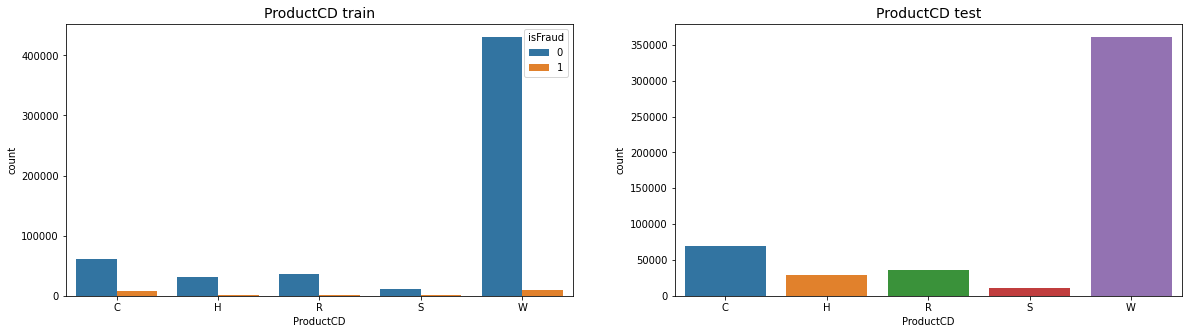

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))

sns.countplot(x="ProductCD", ax=ax[0], hue = "isFraud", data=train)
ax[0].set_title('ProductCD train', fontsize=14)
sns.countplot(x="ProductCD", ax=ax[1], data=test)
ax[1].set_title('ProductCD test', fontsize=14)
plt.show()

### Cards Features

Text(0, 0.5, 'Transaction Values')

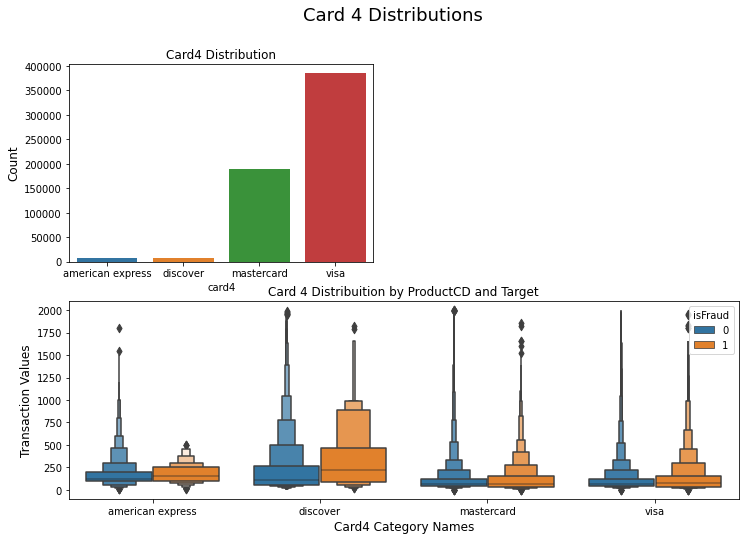

In [11]:
plt.figure(figsize=(12,8))
plt.suptitle('Card 4 Distributions', fontsize=18)

plt.subplot(221)
g1 = sns.countplot(x='card4', data=train)
g1 = sns.countplot(x='card4', data=train)
g1.set_title("Card4 Distribution", fontsize=12)
g1.set_ylabel("Count", fontsize=12)

plt.subplot(212)
g2 = sns.boxenplot(x='card4', y='TransactionAmt', hue='isFraud', 
              data=train[train['TransactionAmt'] <= 2000] )
g2.set_title("Card 4 Distribuition by ProductCD and Target", fontsize=12)
g2.set_xlabel("Card4 Category Names", fontsize=12)
g2.set_ylabel("Transaction Values", fontsize=12)


Text(0, 0.5, 'Transaction Values')

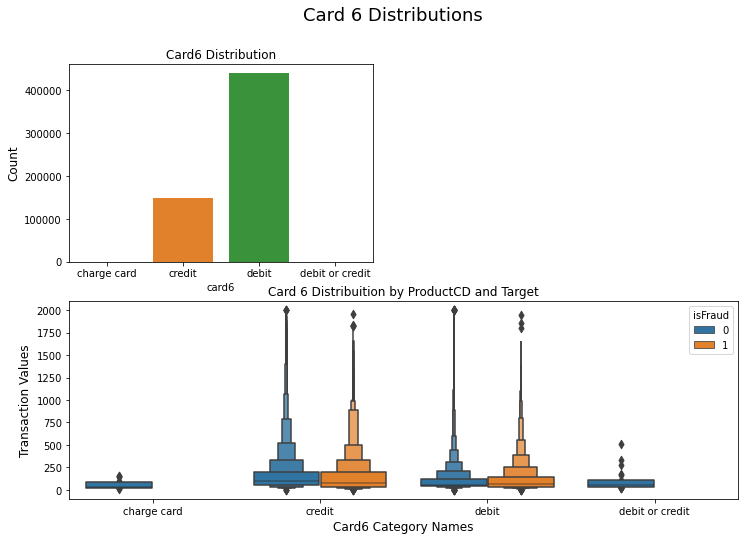

In [12]:
plt.figure(figsize=(12,8))
plt.suptitle('Card 6 Distributions', fontsize=18)

plt.subplot(221)
g = sns.countplot(x='card6', data=train)
g.set_title("Card6 Distribution", fontsize=12)
g.set_ylabel("Count", fontsize=12)

plt.subplot(212)
g1 = sns.boxenplot(x='card6', y='TransactionAmt', hue='isFraud', 
              data=train[train['TransactionAmt'] <= 2000] )
g1.set_title("Card 6 Distribuition by ProductCD and Target", fontsize=12)
g1.set_xlabel("Card6 Category Names", fontsize=12)
g1.set_ylabel("Transaction Values", fontsize=12)


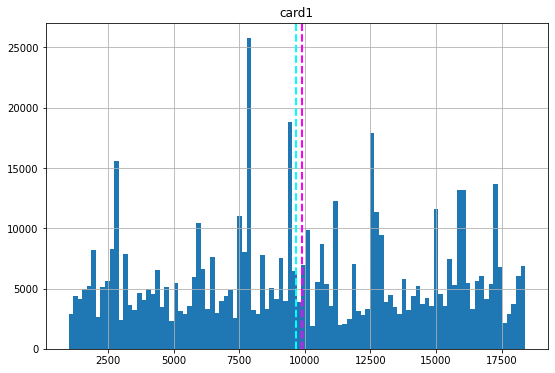

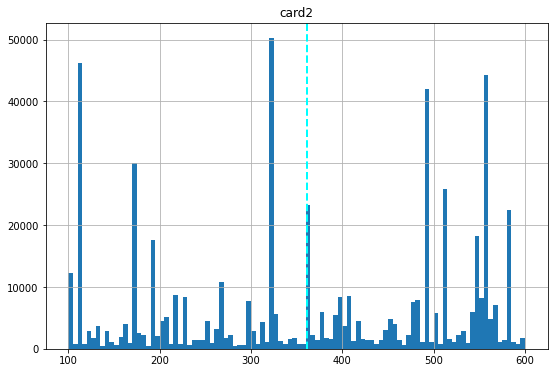

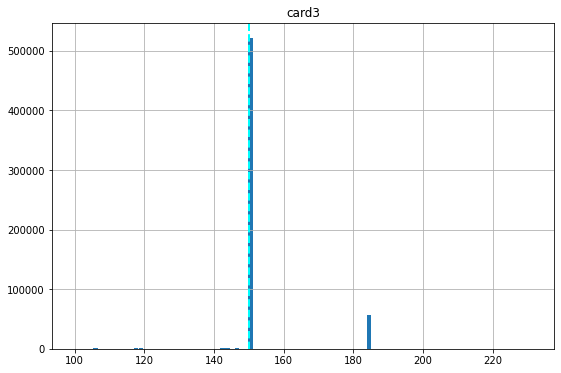

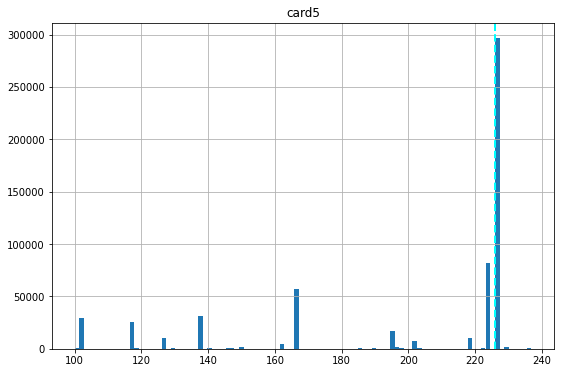

In [13]:
cards = ['card1', 'card2', 'card3', 'card5']

for col in cards:
    fig = plt.figure(figsize = (9,6))
    ax = fig.gca()
    feature = train[col]
    feature.hist(bins = 100, ax=ax)
    ax.axvline(feature.mean(), color = 'magenta', linestyle = 'dashed', linewidth = 2)
    ax.axvline(feature.median(), color= 'cyan', linestyle = 'dashed', linewidth = 2)
    ax.set_title(col)
plt.show()

### Addr1 and Addr2 Features

In [14]:
print("Card Features Quantiles: ")
print(train[['addr1', 'addr2']].quantile([0.01, 0.025, 0.1, 0.25, 0.5, 0.75, 0.9, 0.975, 0.99]))

Card Features Quantiles: 
       addr1  addr2
0.010  123.0   87.0
0.025  123.0   87.0
0.100  177.0   87.0
0.250  204.0   87.0
0.500  299.0   87.0
0.750  330.0   87.0
0.900  441.0   87.0
0.975  498.0   87.0
0.990  512.0   87.0


### C1-C14 Features

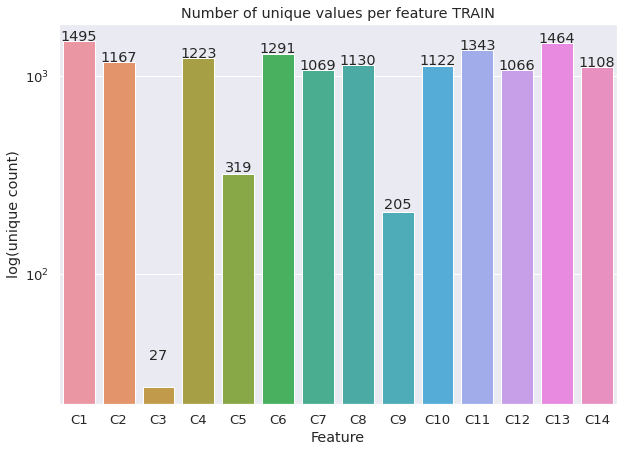

In [15]:
plt.figure(figsize=(10, 7))
c_features = list(train.columns[17:31])
uniques = [len(train[col].unique()) for col in c_features]
sns.set(font_scale=1.2)
ax = sns.barplot(c_features, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature TRAIN')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

### D1-D15 Features

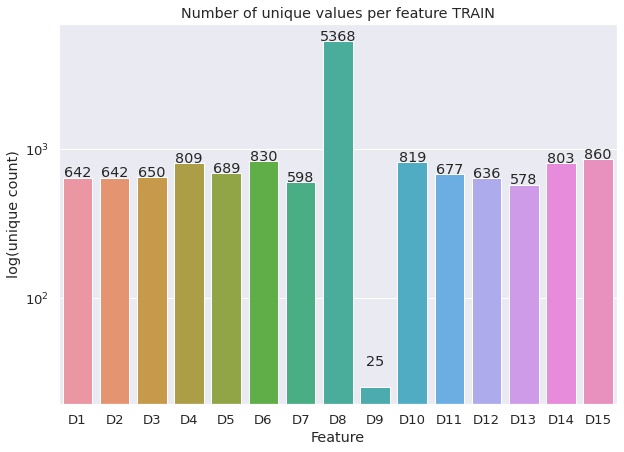

In [16]:
plt.figure(figsize=(10, 7))
d_features = list(train.columns[31:46])
uniques = [len(train[col].unique()) for col in d_features]
sns.set(font_scale=1.2)
ax = sns.barplot(d_features, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature TRAIN')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

### V1-V339 Features

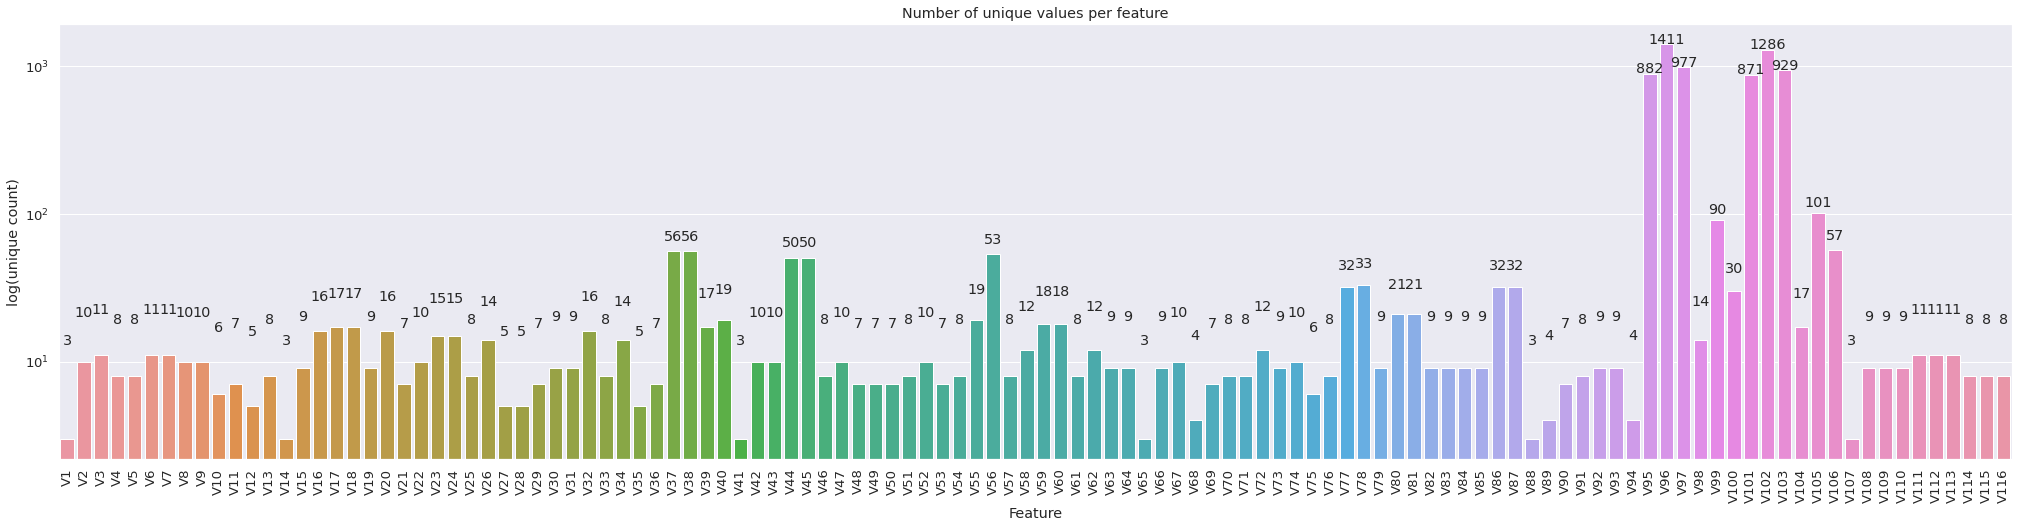

In [17]:
plt.figure(figsize=(35, 8))
v_features = list(train.columns[55:171])
uniques = [len(train[col].unique()) for col in v_features]
sns.set(font_scale=1.2)
ax = sns.barplot(v_features, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature')
ax.set_xticklabels(v_features, rotation = 90)
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

### Device Type in Train Identity

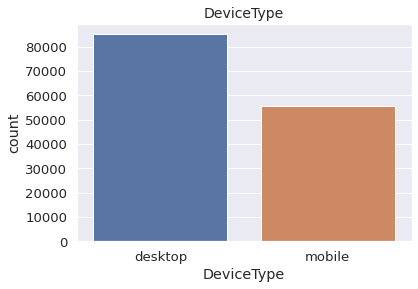

In [18]:
ax = sns.countplot(x="DeviceType", data=train)
ax.set_title('DeviceType', fontsize=14)
sns.set(rc={"figure.figsize": (3,4)})
plt.show()

### Device Information in Train Identity

In [19]:
print ("Unique Devices = ",train['DeviceInfo'].nunique())
train['DeviceInfo'].value_counts().head()

Unique Devices =  1786


Windows        47722
iOS Device     19782
MacOS          12573
Trident/7.0     7440
rv:11.0         1901
Name: DeviceInfo, dtype: int64

# Data Preparation

In [20]:
def summary(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values

    return summary

In [21]:
summary(train)

Dataset Shape: (590540, 434)


,Name,dtypes,Missing,Uniques
0,TransactionID,int32,0,590540
1,isFraud,int8,0,2
2,TransactionDT,int32,0,573349
3,TransactionAmt,float16,0,8195
4,ProductCD,category,0,5
...,...,...,...,...
429,id_36,category,449555,2
430,id_37,category,449555,2
431,id_38,category,449555,2
432,DeviceType,category,449730,2


In [22]:
summary(test)

Dataset Shape: (506691, 433)


,Name,dtypes,Missing,Uniques
0,TransactionID,int32,0,506691
1,TransactionDT,int32,0,494686
2,TransactionAmt,float16,0,7343
3,ProductCD,category,0,5
4,card1,int16,0,13244
...,...,...,...,...
428,id-36,category,369714,2
429,id-37,category,369714,2
430,id-38,category,369714,2
431,DeviceType,category,369760,2


## Feature Transformation
### Handling and Genearating Features

In [23]:
def Devices(df):
    df['device_name'] = df['DeviceInfo'].str.split('/', expand=True)[0]
    df['device_version'] = df['DeviceInfo'].str.split('/', expand=True)[1]
    df = df.drop(['DeviceInfo'], axis = 1)
    
    df['OS_id_30'] = df['id_30'].str.split(' ', expand=True)[0]
    df['version_id_30'] = df['id_30'].str.split(' ', expand=True)[1]
    df = df.drop(['id_30'], axis = 1)
    
    df['browser_id_31'] = df['id_31'].str.split(' ', expand=True)[0]
    df['version_id_31'] = df['id_31'].str.split(' ', expand=True)[1]
    df = df.drop(['id_31'], axis = 1)

    df['screen_width'] = df['id_33'].str.split('x', expand=True)[0]
    df['screen_height'] = df['id_33'].str.split('x', expand=True)[1]
    df = df.drop(['id_33'], axis = 1)

    df['id_34'] = df['id_34'].str.split(':', expand=True)[1]
    df['id_23'] = df['id_23'].str.split(':', expand=True)[1]
    df = df.drop(['id_34', 'id_23'], axis = 1)


    df.loc[df['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
    df.loc[df['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
    df.loc[df['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
    df.loc[df['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
    df.loc[df['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
    df.loc[df['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
    df.loc[df['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
    df.loc[df['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'

    df.loc[df.device_name.isin(df.device_name.value_counts()[df.device_name.value_counts() < 200].index), 'device_name'] = "Others"
    df['had_id'] = 1
    gc.collect()
    
    return df

In [24]:
train = Devices(train)

## Dealing with Missing Data

### Identifying the uniqueness of categorical features

In [25]:
train.drop_duplicates(inplace = True)

We are going to drop the columns with more than 80% missing values baed on [THIS](https://medium.com/analytics-vidhya/how-to-handle-missing-values-cbd03fb79ef8) paper.

Let us now fill all the missing values. For numerical columns, we will use median value and for categorical column, we will use the most frequent category to fill the missing values.

In [26]:
y = train['isFraud']
TransactionID = train['TransactionID']
TransactionDT = train['TransactionDT']
gc.collect()

21

In [27]:
del test

In [28]:
# Dropping columns with more than 80% missing values 
print("Shape before dropping features more than 20% missing values: ", train.shape)
mv = train.isnull().sum()/len(train)
train = train.drop(columns=mv[mv>0.8].index)

print("Shape after dropping features more than 20% missing values: ", train.shape)

Shape before dropping features more than 20% missing values:  (590540, 437)
Shape after dropping features more than 20% missing values:  (590540, 362)


In [29]:
train.dropna(how= 'all', axis = 0)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_29,id_35,id_36,id_37,id_38,DeviceType,device_name,browser_id_31,version_id_31,had_id
0,2987000,0,86400,68.500000,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,2987001,0,86401,29.000000,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,2987002,0,86469,59.000000,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,2987003,0,86499,50.000000,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,2987004,0,86506,50.000000,H,4497,514.0,150.0,mastercard,102.0,...,NotFound,T,F,T,T,mobile,Samsung,samsung,browser,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.000000,W,6550,NaN,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
590536,3577536,0,15811049,39.500000,W,10444,225.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
590537,3577537,0,15811079,30.953125,W,12037,595.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
590538,3577538,0,15811088,117.000000,W,7826,481.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


Based on metadata Categorical Featurs are:

* ProductCD
* emaildomain
* card4 - card6
* addr1, addr2
* P_emaildomain
* R_emaildomain
* M1 - M9
* DeviceType
* DeviceInfo
* id_12 - id_38

However, by filtering the features based on the data type (obj) we have more categorical features.

In [30]:
train = train.drop(['isFraud', 'TransactionID', 'TransactionDT'], axis = 1)
# Filtering numerical data
num_df = train.select_dtypes(include=np.number)
print(num_df.shape)

# Filtering categorical data
cat_df = train.select_dtypes(exclude=np.number)
print(cat_df.shape)

(590540, 332)
(590540, 27)


In [31]:
num_df.head()

,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,C2,...,id_01,id_02,id_05,id_06,id_11,id_13,id_17,id_19,id_20,had_id
0,68.5,13926,NaN,150.0,142.0,315.0,87.0,19.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,29.0,2755,404.0,150.0,102.0,325.0,87.0,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,59.0,4663,490.0,150.0,166.0,330.0,87.0,287.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,50.0,18132,567.0,150.0,117.0,476.0,87.0,NaN,2.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,50.0,4497,514.0,150.0,102.0,420.0,87.0,NaN,1.0,1.0,...,0.0,70787.0,NaN,NaN,100.0,NaN,166.0,542.0,144.0,1


In [32]:
cat_df.head()

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,...,id_28,id_29,id_35,id_36,id_37,id_38,DeviceType,device_name,browser_id_31,version_id_31
0,W,discover,credit,NaN,NaN,T,T,T,M2,F,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,W,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,M0,T,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,W,visa,debit,outlook.com,NaN,T,T,T,M0,F,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,W,mastercard,debit,yahoo.com,NaN,NaN,NaN,NaN,M0,T,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,H,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,...,New,NotFound,T,F,T,T,mobile,Samsung,samsung,browser


In [33]:
gc.collect()

21

In [34]:
# Filling missing values by median for numerical columns 
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
num_df = pd.DataFrame(imp_median.fit_transform(num_df), columns=num_df.columns)
print(num_df.shape)

# Filling missing values by most frequent value for categorical columns
imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
cat_df = pd.DataFrame(imp_mode.fit_transform(cat_df), columns=cat_df.columns)

#for column in cat_df.columns:
#    cat_df[column].fillna(cat_df[column].mode()[0], inplace=True)

    
cat_df.isnull().sum()
num_df.isnull().sum()

(590540, 332)


TransactionAmt    0
card1             0
card2             0
card3             0
card5             0
                 ..
id_13             0
id_17             0
id_19             0
id_20             0
had_id            0
Length: 332, dtype: int64

## Numerical Features

In [35]:
scaled_num = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(num_df), columns = num_df.columns)
scaled_num.head()

,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,C2,...,id_01,id_02,id_05,id_06,id_11,id_13,id_17,id_19,id_20,had_id
0,0.002137,0.743044,0.522,0.381679,0.306569,0.488636,0.836957,0.001847,0.000213,0.000176,...,0.95,0.125851,0.580645,1.0,1.0,0.777778,0.511628,0.422067,0.663102,0.0
1,0.000900,0.100885,0.608,0.381679,0.014599,0.511364,0.836957,0.000778,0.000213,0.000176,...,0.95,0.125851,0.580645,1.0,1.0,0.777778,0.511628,0.422067,0.663102,0.0
2,0.001840,0.210566,0.780,0.381679,0.481752,0.522727,0.836957,0.027897,0.000213,0.000176,...,0.95,0.125851,0.580645,1.0,1.0,0.777778,0.511628,0.422067,0.663102,0.0
3,0.001558,0.984824,0.934,0.381679,0.124088,0.854545,0.836957,0.000778,0.000427,0.000878,...,0.95,0.125851,0.580645,1.0,1.0,0.777778,0.511628,0.422067,0.663102,0.0
4,0.001558,0.201023,0.828,0.381679,0.014599,0.727273,0.836957,0.000778,0.000213,0.000176,...,1.00,0.070815,0.580645,1.0,1.0,0.777778,0.511628,0.774081,0.078431,0.0


### PCA for Numerical Features

Text(0, 0.5, 'Cumulative Rate of Variance')

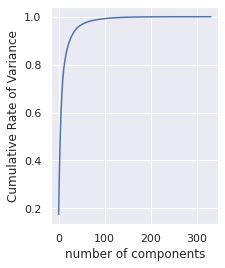

In [36]:
pca = PCA().fit(scaled_num)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("number of components")
plt.ylabel("Cumulative Rate of Variance")

In [37]:
#final
pca = PCA(n_components = 0.95)

pca_fit = pca.fit_transform(scaled_num)
columns = train.columns[43:83] # setting an string name for columns for surpressing sklearn future error.
num_pca = pd.DataFrame(data = pca_fit, columns=columns)
pca.explained_variance_ratio_.sum()
del num_df, scaled_num

In [38]:
del train
num_pca.head()

,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39
0,-0.323767,-0.195413,0.165047,0.427136,0.045425,-0.186387,0.063809,-0.061365,-0.064428,-0.080384,...,-0.007998,-0.025171,-0.016574,0.035473,-0.006006,-0.010612,0.004359,-0.001721,-0.073779,-0.003276
1,-0.366990,0.269999,0.131883,0.182788,0.673383,-0.025724,0.096363,0.213207,-0.049690,-0.418528,...,-0.004724,0.011852,0.012607,-0.018629,-0.003677,0.002857,0.008616,0.004802,-0.007791,-0.016422
2,-0.076643,-0.157790,-0.199622,0.119463,0.420860,-0.200106,0.106679,0.097227,-0.202645,0.195683,...,-0.023139,0.002008,0.025556,0.017241,-0.008901,0.000854,0.015355,0.002122,-0.009984,-0.002584
3,-0.204429,-0.035661,-0.128648,0.859522,-0.011436,-0.228297,0.410293,-0.023283,-0.090311,-0.063734,...,-0.014402,-0.015144,0.001526,-0.001284,-0.022878,0.149148,0.004521,-0.048259,0.074443,-0.009957
4,-0.391432,-0.134168,-0.106163,0.423674,0.660365,-0.249032,0.361606,-0.002510,-0.107527,-0.072404,...,0.023231,0.019881,-0.017445,-0.024127,0.013637,0.000573,0.021267,-0.004428,-0.004140,-0.021780


## Categorical Features

Due to we have too many values in some categories, we try to map them into new categories.

In [39]:
for x in cat_df.columns:
    #printing unique values
    print(x ,':', len(cat_df[x].unique()))

ProductCD : 5
card4 : 4
card6 : 4
P_emaildomain : 59
R_emaildomain : 60
M1 : 2
M2 : 2
M3 : 2
M4 : 3
M5 : 2
M6 : 2
M7 : 2
M8 : 2
M9 : 2
id_12 : 2
id_15 : 3
id_16 : 2
id_28 : 2
id_29 : 2
id_35 : 2
id_36 : 2
id_37 : 2
id_38 : 2
DeviceType : 2
device_name : 13
browser_id_31 : 39
version_id_31 : 40


In [40]:
cat_df = pd.get_dummies(cat_df)
cat_df.head()

,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,card4_american express,card4_discover,card4_mastercard,card4_visa,card6_charge card,...,version_id_31_67.0,version_id_31_69.0,version_id_31_7.0,version_id_31_9.0,version_id_31_browser,version_id_31_generic,version_id_31_mobile,version_id_31_safari,version_id_31_search,version_id_31_webview
0,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


# Tree-based Categorical Feature Selection

In [41]:
start = time.time()


clf = ExtraTreesClassifier()

param_grid = {'criterion': ['gini', 'entropy', 'log_loss'],
              'max_depth': [20, 30, 40],
              'min_samples_leaf': [1, 3],
              'min_samples_split': [2, 4, 6],
              'n_estimators': [50, 100, 150, 200]
             }

ETC_clf = RandomizedSearchCV(estimator = clf,
                            param_distributions = param_grid,
                            scoring = 'roc_auc',
                            cv= 2,
                            verbose=1,
                            n_jobs = -1)

ETC_clf.fit(cat_df, y)
print('Best parameters found:\n', ETC_clf.best_params_)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
Best parameters found:
 {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 20, 'criterion': 'entropy'}


In [42]:
model = SelectFromModel(ETC_clf.best_estimator_, prefit = True)
feature_idx = model.get_support()
feature_name = cat_df.columns[feature_idx]

cat_new = pd.DataFrame(model.transform(cat_df), columns = feature_name)
cat_new.head()

,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_W,card4_discover,card4_mastercard,card4_visa,card6_credit,card6_debit,P_emaildomain_anonymous.com,...,device_name_Others,device_name_Samsung,device_name_Windows,browser_id_31_chrome,browser_id_31_mobile,version_id_31_63.0,version_id_31_64.0,version_id_31_65.0,version_id_31_generic,version_id_31_safari
0,0,0,0,1,1,0,0,1,0,0,...,0,0,1,1,0,0,0,0,0,1
1,0,0,0,1,0,1,0,1,0,0,...,0,0,1,1,0,0,0,0,0,1
2,0,0,0,1,0,0,1,0,1,0,...,0,0,1,1,0,0,0,0,0,1
3,0,0,0,1,0,1,0,0,1,0,...,0,0,1,1,0,0,0,0,0,1
4,0,1,0,0,0,1,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0


### Concatenating Numerical and Categorical Features 

In [43]:
# Concatinating numerical and categorical data
df = pd.concat([y, TransactionID, TransactionDT, num_pca, cat_new], axis=1)
df = pd.DataFrame(df)

# Verifying missing values
print(f'Total missing values: {df.isnull().sum().sum()}')
print(df.shape)
df.head()

Total missing values: 0
(590540, 104)


,isFraud,TransactionID,TransactionDT,M9,V1,V2,V3,V4,V5,V6,...,device_name_Others,device_name_Samsung,device_name_Windows,browser_id_31_chrome,browser_id_31_mobile,version_id_31_63.0,version_id_31_64.0,version_id_31_65.0,version_id_31_generic,version_id_31_safari
0,0,2987000,86400,-0.323767,-0.195413,0.165047,0.427136,0.045425,-0.186387,0.063809,...,0,0,1,1,0,0,0,0,0,1
1,0,2987001,86401,-0.366990,0.269999,0.131883,0.182788,0.673383,-0.025724,0.096363,...,0,0,1,1,0,0,0,0,0,1
2,0,2987002,86469,-0.076643,-0.157790,-0.199622,0.119463,0.420860,-0.200106,0.106679,...,0,0,1,1,0,0,0,0,0,1
3,0,2987003,86499,-0.204429,-0.035661,-0.128648,0.859522,-0.011436,-0.228297,0.410293,...,0,0,1,1,0,0,0,0,0,1
4,0,2987004,86506,-0.391432,-0.134168,-0.106163,0.423674,0.660365,-0.249032,0.361606,...,0,1,0,0,0,0,0,0,0,0


In [44]:
del  cat_new, num_pca, y
gc.collect()

550

### Class Imbalance

We applied udersampling to decrease the modeling time and better identifieying the isFraud target feature.

In [45]:
y = df['isFraud']
X = df.drop(['isFraud', 'TransactionID', 'TransactionDT'], axis = 1)
X_array=np.array(X)

rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X, y)

print(X_resampled.shape, y_resampled.shape)

pd.value_counts(y_resampled)

(41326, 101) (41326,)


0    20663
1    20663
Name: isFraud, dtype: int64

In [46]:
X_df = pd.DataFrame(X_resampled, columns = X.columns)
y_df = pd.DataFrame(y_resampled)
df = pd.concat([X_df, y_df], axis= 1)
df.shape 
df.head()

,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,device_name_Samsung,device_name_Windows,browser_id_31_chrome,browser_id_31_mobile,version_id_31_63.0,version_id_31_64.0,version_id_31_65.0,version_id_31_generic,version_id_31_safari,isFraud
0,-0.087592,-0.374095,-0.381445,-0.146859,0.249199,0.422486,0.472326,-0.136101,0.084228,0.030195,...,0,1,1,0,0,0,0,0,1,0
1,0.085232,0.212418,0.074641,-0.298410,-0.146149,-0.240662,0.362392,0.104383,0.147924,-0.101005,...,0,1,1,0,0,0,0,0,0,0
2,0.296208,-0.145063,-0.079162,0.039249,-0.191022,-0.335111,-0.064968,-0.172277,0.087158,-0.037125,...,0,1,1,0,0,0,0,0,1,0
3,-0.234173,-0.321034,-0.188541,0.011107,-0.262307,-0.213643,0.333575,-0.016358,-0.029165,0.002905,...,0,1,1,0,0,0,0,0,0,0
4,-0.185464,-0.368929,0.405462,-0.219486,-0.293010,-0.218691,-0.212299,-0.059799,-0.028717,0.029445,...,0,0,0,1,0,0,0,0,1,0


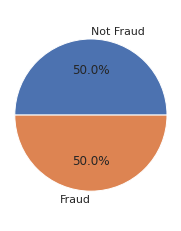

In [47]:
# Class imbalance check
plt.pie(y_df.value_counts(), labels=['Not Fraud', 'Fraud'], autopct='%0.1f%%')
plt.axis('equal')
plt.show()

In [48]:
df.shape 

(41326, 102)

In [49]:
del X_df, y_df, X_resampled, y_resampled
gc.collect()

2360

# Modeling

In [50]:
y = df['isFraud']
X = df.drop(['isFraud'], axis = 1)

## Naive Bayes

accuracy    = 0.6678 ±0.0026
recall      = 0.6678 ±0.0026
precision   = 0.6901 ±0.0040
f1          = 0.6715 ±0.0027


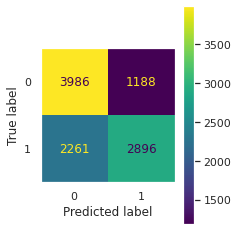

In [51]:
nb_clf = naive_bayes.BernoulliNB()

kf = KFold(n_splits = 4, shuffle = True, random_state=42)

acc, prec, rec, f1 = [], [], [], []
for train_index, test_index in kf.split(df):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    nb_clf.fit(X_train, y_train)
    y_pred = nb_clf.predict(X_test)
    acc += [metrics.accuracy_score(y_pred, y_test)]
    rec += [metrics.recall_score(y_pred, y_test, average="weighted")]
    prec += [metrics.precision_score(y_pred, y_test, average="weighted")]
    f1 += [metrics.f1_score(y_pred, y_test, average="weighted")]


print("accuracy    = {:.4f} ±{:.4f}".format(np.mean(acc), np.std(acc)))
print("recall      = {:.4f} ±{:.4f}".format(np.mean(rec), np.std(rec)))
print("precision   = {:.4f} ±{:.4f}".format(np.mean(prec), np.std(prec)))
print("f1          = {:.4f} ±{:.4f}".format(np.mean(f1), np.std(f1)))

metrics.plot_confusion_matrix(nb_clf, X_test, y_test).ax_.grid(False)

With GuassianNB the scores are relatively lower.

0.7478908878906247


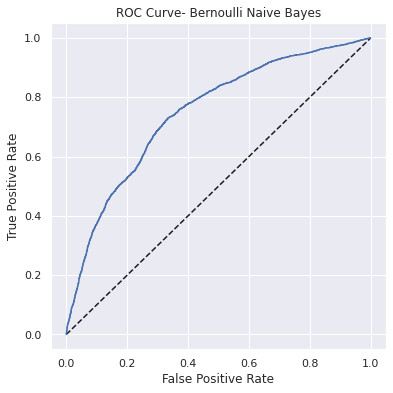

In [52]:
y_scores = nb_clf.predict_proba(X_test)

# calculate ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_scores[:,1])
NBScore = metrics.auc(fpr, tpr)
print(NBScore)


# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve- Bernoulli Naive Bayes')
plt.show()

## Logistic Regression

accuracy    = 0.7509 ±0.0026
recall      = 0.7509 ±0.0026
precision   = 0.7533 ±0.0028
f1          = 0.7512 ±0.0026


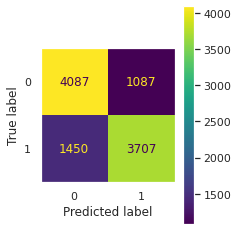

In [53]:

lg_clf = LogisticRegression(solver="liblinear")

kf = KFold(n_splits = 4, shuffle = True, random_state=42)

acc, prec, rec, f1 = [], [], [], []
for train_index, test_index in kf.split(df):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    lg_clf.fit(X_train, y_train)
    y_pred = lg_clf.predict(X_test)
    
    acc += [metrics.accuracy_score(y_pred, y_test)]
    rec += [metrics.recall_score(y_pred, y_test, average="weighted")]
    prec += [metrics.precision_score(y_pred, y_test, average="weighted")]
    f1 += [metrics.f1_score(y_pred, y_test, average="weighted")]

print("accuracy    = {:.4f} ±{:.4f}".format(np.mean(acc), np.std(acc)))
print("recall      = {:.4f} ±{:.4f}".format(np.mean(rec), np.std(rec)))
print("precision   = {:.4f} ±{:.4f}".format(np.mean(prec), np.std(prec)))
print("f1          = {:.4f} ±{:.4f}".format(np.mean(f1), np.std(f1)))

metrics.plot_confusion_matrix(lg_clf, X_test, y_test).ax_.grid(False)

0.8325772895743166


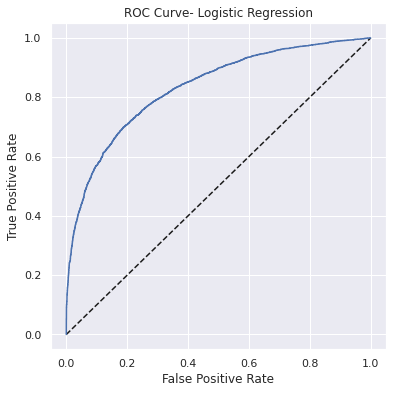

In [54]:
y_scores = lg_clf.predict_proba(X_test)

# calculate ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_scores[:,1])
LGScore = metrics.auc(fpr, tpr)
print(LGScore)


# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve- Logistic Regression')
plt.show()

## KNN Classifier
### Tuning

Text(0, 0.5, 'Error Rate')

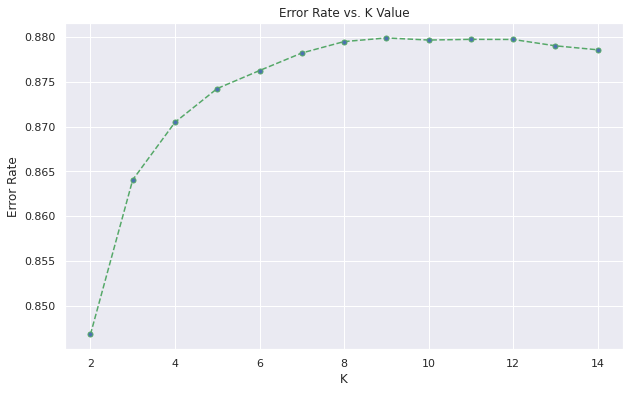

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

error_rate = []
for i in range(2,15):
    knn = KNeighborsClassifier(n_neighbors=i, weights='distance')
    knn.fit(X_train,y_train)
    pred_i = knn.predict_proba(X_test)
    error_rate.append(metrics.roc_auc_score(y_test, pred_i[:,1]))

plt.figure(figsize=(10,6))
plt.plot(range(2,15), error_rate,color='g', linestyle='dashed', marker='o', markerfacecolor='b', markersize=5)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [56]:
knn_clf = KNeighborsClassifier(n_neighbors=9, weights='distance')

kf = KFold(n_splits = 4, shuffle = True, random_state=42)

acc, prec, rec, f1 = [], [], [], []
for train_index, test_index in kf.split(df):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    knn_clf.fit(X_train, y_train)
    y_pred = knn_clf.predict(X_test)
    
    acc += [metrics.accuracy_score(y_pred, y_test)]
    rec += [metrics.recall_score(y_pred, y_test, average="weighted")]
    prec += [metrics.precision_score(y_pred, y_test, average="weighted")]
    f1 += [metrics.f1_score(y_pred, y_test, average="weighted")]
    

print("accuracy    = {:.4f} ±{:.4f}".format(np.mean(acc), np.std(acc)))
print("recall      = {:.4f} ±{:.4f}".format(np.mean(rec), np.std(rec)))
print("precision   = {:.4f} ±{:.4f}".format(np.mean(prec), np.std(prec)))
print("f1          = {:.4f} ±{:.4f}".format(np.mean(f1), np.std(f1)))

accuracy    = 0.7996 ±0.0035
recall      = 0.7996 ±0.0035
precision   = 0.8027 ±0.0032
f1          = 0.7999 ±0.0035


0.8817166297171034


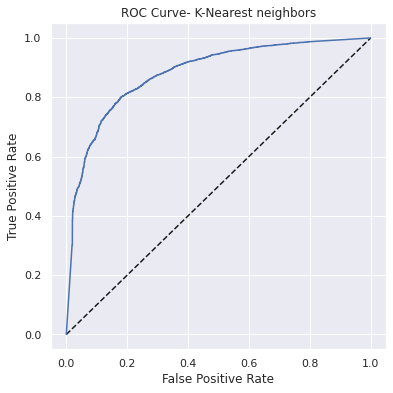

In [57]:
y_scores = knn_clf.predict_proba(X_test)

# calculate ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_scores[:,1])
KNScore = metrics.auc(fpr, tpr)
print(KNScore)

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve- K-Nearest neighbors')
plt.show()

## Support Vector Machine (SVM)

We applied a simple gridsearch prior to selectiong the parameters and due to time consuming we remove the gridsearch cell.

In [58]:
svm_clf = SVC(kernel = 'linear', C= 5)

kf = KFold(n_splits = 4, shuffle = True, random_state=42)

acc, prec, rec, f1 = [], [], [], []
for train_index, test_index in kf.split(df):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    svm_clf.fit(X_train, y_train)
    y_pred = svm_clf.predict(X_test)
    
    acc += [metrics.accuracy_score(y_pred, y_test)]
    rec += [metrics.recall_score(y_pred, y_test, average="weighted")]
    prec += [metrics.precision_score(y_pred, y_test, average="weighted")]
    f1 += [metrics.f1_score(y_pred, y_test, average="weighted")]
    

print("accuracy    = {:.4f} ±{:.4f}".format(np.mean(acc), np.std(acc)))
print("recall      = {:.4f} ±{:.4f}".format(np.mean(rec), np.std(rec)))
print("precision   = {:.4f} ±{:.4f}".format(np.mean(prec), np.std(prec)))
print("f1          = {:.4f} ±{:.4f}".format(np.mean(f1), np.std(f1)))

accuracy    = 0.7497 ±0.0022
recall      = 0.7497 ±0.0022
precision   = 0.7565 ±0.0025
f1          = 0.7506 ±0.0021


0.7516217294164622


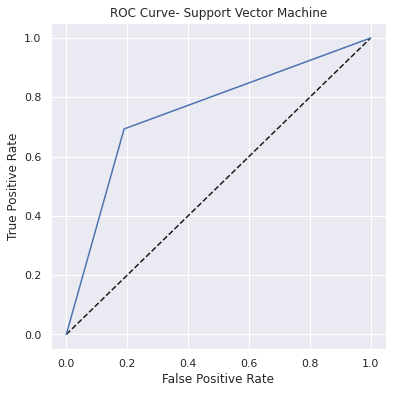

In [59]:
# calculate ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
SVScore= metrics.auc(fpr, tpr)
print(SVScore)

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve- Support Vector Machine')
plt.show()

In [60]:
gc.collect()

27746

## MLP Classifier

### Tuning

In [61]:
parameter_space = {
    'max_iter': [500, 1000, 2000],
    'hidden_layer_sizes': [(10, ), (20,)],
    'activation': ['tanh', 'relu'],
    'alpha': [0.01, 0.1, 0.5, 0.9],
}
MLP_clf = GridSearchCV(MLPClassifier(), parameter_space, n_jobs=-1, cv=2)
MLP_clf.fit(X_train, y_train)

GridSearchCV(cv=2, estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.01, 0.1, 0.5, 0.9],
                         'hidden_layer_sizes': [(10,), (20,)],
                         'max_iter': [500, 1000, 2000]})

In [62]:
print('Best parameters found:\n', MLP_clf.best_params_)

Best parameters found:
 {'activation': 'tanh', 'alpha': 0.9, 'hidden_layer_sizes': (20,), 'max_iter': 1000}


In [63]:
kfold = KFold(n_splits =4, shuffle=True, random_state=42)

acc, prec, rec, f1 = [], [], [], []

for train_idx, test_idx in kfold.split(df):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    X_scaler = preprocessing.MinMaxScaler()
    X_train = X_scaler.fit_transform(X_train)
    mlp_clf = MLP_clf.best_estimator_   
    y_pred = mlp_clf.predict(X_test)
    
    acc += [metrics.accuracy_score(y_pred, y_test)]
    rec += [metrics.recall_score(y_pred, y_test, average= 'weighted')]
    prec += [metrics.precision_score(y_pred, y_test, average= 'weighted')]
    f1 += [metrics.f1_score(y_pred, y_test, average= 'weighted')]
    
print("accuracy    = {:.4f} ±{:.4f}".format(np.mean(acc), np.std(acc)))
print("recall    = {:.4f} ±{:.4f}".format(np.mean(rec), np.std(rec)))
print("precision = {:.4f} ±{:.4f}".format(np.mean(prec), np.std(prec)))
print("f1        = {:.4f} ±{:.4f}".format(np.mean(f1), np.std(f1)))

accuracy    = 0.7426 ±0.0017
recall    = 0.7426 ±0.0017
precision = 0.7506 ±0.0024
f1        = 0.7436 ±0.0018


0.8294268136673881


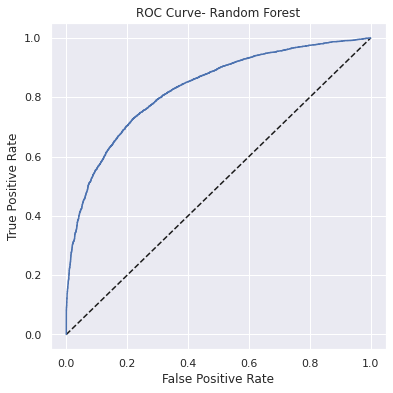

In [64]:
y_scores = mlp_clf.predict_proba(X_test)

# calculate ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_scores[:,1])
MLPScore = metrics.auc(fpr, tpr)
print(MLPScore)


# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve- Random Forest')
plt.show()

## Decision Tree Classifier

In [65]:
dt_clf = DecisionTreeClassifier(criterion = 'entropy', random_state = 42)

kf = KFold(n_splits = 4, shuffle = True, random_state=42)

acc, prec, rec, f1 = [], [], [], []
for train_index, test_index in kf.split(df):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    dt_clf.fit(X_train, y_train)
    y_pred = dt_clf.predict(X_test)
    acc += [metrics.accuracy_score(y_pred, y_test)]
    rec += [metrics.recall_score(y_pred, y_test, average="weighted")]
    prec += [metrics.precision_score(y_pred, y_test, average="weighted")]
    f1 += [metrics.f1_score(y_pred, y_test, average="weighted")]
    
print("accuracy    = {:.4f} ±{:.4f}".format(np.mean(acc), np.std(acc)))
print("recall      = {:.4f} ±{:.4f}".format(np.mean(rec), np.std(rec)))
print("precision   = {:.4f} ±{:.4f}".format(np.mean(prec), np.std(prec)))
print("f1          = {:.4f} ±{:.4f}".format(np.mean(f1), np.std(f1)))

accuracy    = 0.7444 ±0.0030
recall      = 0.7444 ±0.0030
precision   = 0.7448 ±0.0031
f1          = 0.7444 ±0.0030


0.7451657311032722


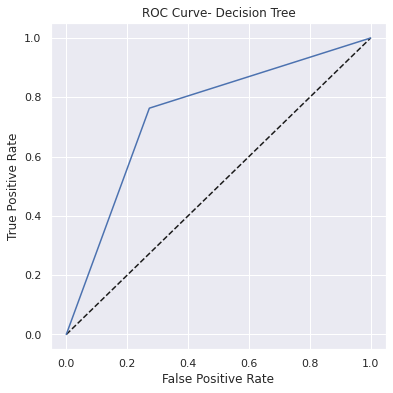

In [66]:
y_scores = dt_clf.predict_proba(X_test)

# calculate ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_scores[:,1])
DTScore = metrics.auc(fpr, tpr)
print(DTScore)


# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve- Decision Tree')
plt.show()

## Random Forest Classifier

We already checked the gini criterion and entropy getts better results.

In [67]:
rf_clf = RandomForestClassifier(criterion = 'entropy')

kf = KFold(n_splits = 4, shuffle = True, random_state=42)

acc, prec, rec, f1 = [], [], [], []
for train_index, test_index in kf.split(df):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    rf_clf.fit(X_train, y_train)
    y_pred = rf_clf.predict(X_test)
    acc += [metrics.accuracy_score(y_pred, y_test)]
    rec += [metrics.recall_score(y_pred, y_test, average="weighted")]
    prec += [metrics.precision_score(y_pred, y_test, average="weighted")]
    f1 += [metrics.f1_score(y_pred, y_test, average="weighted")]
    
print("accuracy    = {:.4f} ±{:.4f}".format(np.mean(acc), np.std(acc)))
print("recall      = {:.4f} ±{:.4f}".format(np.mean(rec), np.std(rec)))
print("precision   = {:.4f} ±{:.4f}".format(np.mean(prec), np.std(prec)))
print("f1          = {:.4f} ±{:.4f}".format(np.mean(f1), np.std(f1)))

accuracy    = 0.8279 ±0.0025
recall      = 0.8279 ±0.0025
precision   = 0.8285 ±0.0026
f1          = 0.8279 ±0.0025


0.9051519999124513


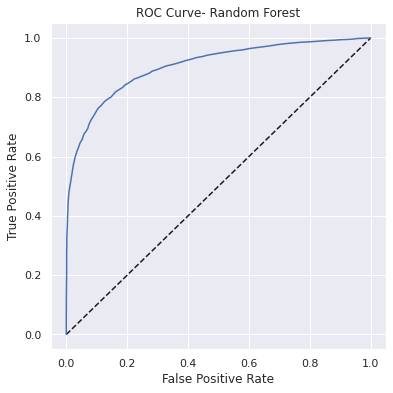

In [68]:
y_scores = rf_clf.predict_proba(X_test)

# calculate ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_scores[:,1])
RFScore = metrics.auc(fpr, tpr)
print(RFScore)


# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve- Random Forest')
plt.show()

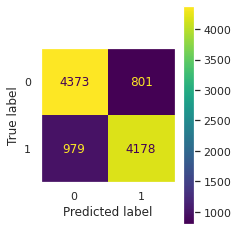

In [69]:
metrics.plot_confusion_matrix(rf_clf, X_test, y_test).ax_.grid(False)

## Bagging Classifier

In [70]:
bc_clf = BaggingClassifier()

kf = KFold(n_splits = 4, shuffle = True, random_state =42)
acc, prec, rec, f1 = [], [], [], []

for train_index, test_index in kf.split(df):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    bc_clf.fit(X_train, y_train)
    y_pred = bc_clf.predict(X_test)
    
    acc += [metrics.accuracy_score(y_pred, y_test)]
    rec += [metrics.recall_score(y_pred, y_test, average="weighted")]
    prec += [metrics.precision_score(y_pred, y_test, average="weighted")]
    f1 += [metrics.f1_score(y_pred, y_test, average="weighted")]


print("accuracy    = {:.4f} ±{:.4f}".format(np.mean(acc), np.std(acc)))
print("recall      = {:.4f} ±{:.4f}".format(np.mean(rec), np.std(rec)))
print("precision   = {:.4f} ±{:.4f}".format(np.mean(prec), np.std(prec)))
print("f1          = {:.4f} ±{:.4f}".format(np.mean(f1), np.std(f1)))

accuracy    = 0.8024 ±0.0012
recall      = 0.8024 ±0.0012
precision   = 0.8058 ±0.0015
f1          = 0.8027 ±0.0013


0.8795734126247952


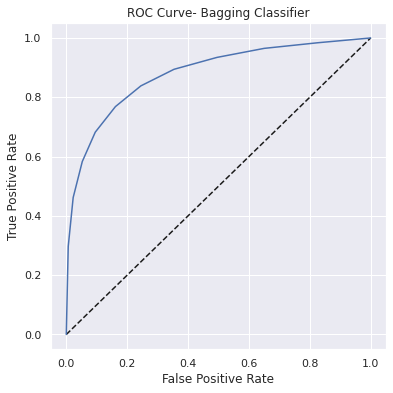

In [71]:
y_scores = bc_clf.predict_proba(X_test)

# calculate ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_scores[:,1])
BCScore = metrics.auc(fpr, tpr)
print(BCScore)


# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve- Bagging Classifier')
plt.show()

## Gradient Boosting Classifier
### Tuning

In [72]:

gb_clf = GradientBoostingClassifier()
kf = KFold(n_splits = 4, shuffle = True, random_state = 42)
acc, prec, rec, f1 = [], [], [], []

for train_index, test_index in kf.split(df):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    gb_clf.fit(X_train, y_train)
    y_pred = gb_clf.predict(X_test)
    
    acc += [metrics.accuracy_score(y_pred, y_test)]
    rec += [metrics.recall_score(y_pred, y_test, average="weighted")]
    prec += [metrics.precision_score(y_pred, y_test, average="weighted")]
    f1 += [metrics.f1_score(y_pred, y_test, average="weighted")]

print("accuracy    = {:.4f} ±{:.4f}".format(np.mean(acc), np.std(acc)))
print("recall      = {:.4f} ±{:.4f}".format(np.mean(rec), np.std(rec)))
print("precision   = {:.4f} ±{:.4f}".format(np.mean(prec), np.std(prec)))
print("f1          = {:.4f} ±{:.4f}".format(np.mean(f1), np.std(f1)))

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


accuracy    = 0.7753 ±0.0037
recall      = 0.7753 ±0.0037
precision   = 0.7775 ±0.0037
f1          = 0.7756 ±0.0037


0.8572522259872624


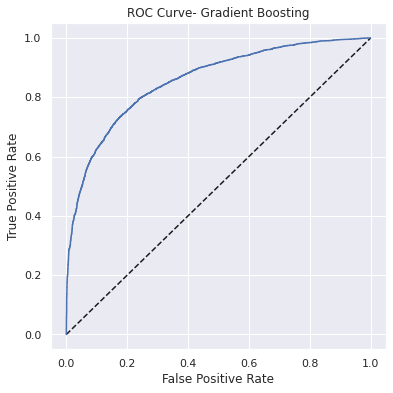

In [73]:
y_scores = gb_clf.predict_proba(X_test)

# calculate ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_scores[:,1])
GBScore = metrics.auc(fpr, tpr)
print(GBScore)

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve- Gradient Boosting')
plt.show()

# Comparing Models

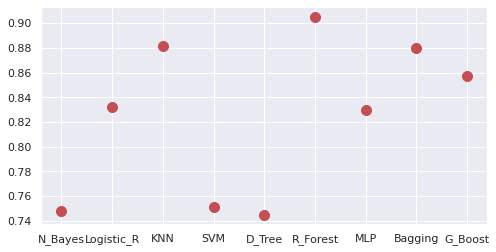

In [74]:
%matplotlib inline

plt.figure(figsize=(8, 4))
plt.plot(['N_Bayes', 'Logistic_R', 'KNN', 'SVM', 'D_Tree', 'R_Forest', 'MLP', 'Bagging', 'G_Boost'],
         [NBScore, LGScore, KNScore, SVScore, DTScore, RFScore, MLPScore, BCScore, GBScore], 'ro', markersize=10)

plt.show()

**We could see Random Forest Classifier has the higherst average score, now we continue to tune and make it as a pipeline after hyperparameter tuning.**

In [75]:
gc.collect()

23194

**we first run a grid search to find out the important string params mostly, and then in the next cell run a RandomGridSearch to find the computationally expensive params**

In [76]:
start = time.time()

rf = RandomForestClassifier()

param_grid = {'bootstrap': [False, True],
              'criterion': ['entropy', 'gini'],
              'max_depth': range(100, 300, 50),
              'max_features': ['auto', 'sqrt'],
              'min_samples_leaf': range (2, 21, 2),
              'min_samples_split': range(1, 11, 2),
              'n_estimators': range(200, 1500, 50)
             }

RF_clf = RandomizedSearchCV(estimator = rf,
                            n_iter = 100,
                            param_distributions = param_grid,
                            scoring = 'roc_auc',
                            cv= 2,
                            verbose=2,
                            n_jobs = -1)

RF_clf.fit(X_train, y_train)
print('Best parameters found:\n', RF_clf.best_params_)
print('Best score :\n', RF_clf.best_score_)

print('Time Spent:', time.time() - start)

Fitting 2 folds for each of 100 candidates, totalling 200 fits
[CV] END bootstrap=False, criterion=entropy, max_depth=200, max_features=sqrt, min_samples_leaf=14, min_samples_split=3, n_estimators=750; total time= 2.1min
[CV] END bootstrap=True, criterion=entropy, max_depth=200, max_features=auto, min_samples_leaf=2, min_samples_split=1, n_estimators=1350; total time=   0.8s
[CV] END bootstrap=True, criterion=entropy, max_depth=200, max_features=auto, min_samples_leaf=2, min_samples_split=1, n_estimators=1350; total time=   0.6s
[CV] END bootstrap=True, criterion=entropy, max_depth=200, max_features=sqrt, min_samples_leaf=14, min_samples_split=1, n_estimators=1050; total time=   0.5s
[CV] END bootstrap=True, criterion=entropy, max_depth=200, max_features=sqrt, min_samples_leaf=14, min_samples_split=1, n_estimators=1050; total time=   0.5s
[CV] END bootstrap=True, criterion=gini, max_depth=150, max_features=auto, min_samples_leaf=16, min_samples_split=1, n_estimators=500; total time=   

In [77]:
best_params = RF_clf.best_estimator_
y_hat = best_params.predict(X_test)
y_scores = best_params.predict_proba(X_test)

print('accuracy: ', metrics.accuracy_score(y_test, y_hat))
print('precision: ', metrics.precision_score(y_test, y_hat, average='weighted'))
print('recal: ', metrics.recall_score(y_test, y_hat, average='weighted'))
print('f1 score: ', metrics.f1_score(y_test, y_hat, average='weighted'))

print('ROC AUC Score: ', metrics.roc_auc_score(y_test, y_scores[:,1]))

accuracy:  0.7960507211305778
precision:  0.7969616618143833
recal:  0.7960507211305778
f1 score:  0.7958815844111512
ROC AUC Score:  0.8806688759200006


# PipeLine and HyperParameters Tuning

**We find out important params in the GridSearchesabove and we could either use undersampling in pipeline or without undersampling.**

**To get a better result we run without undersampling**

In [78]:
# loading train_transaction data
tt = pd.read_csv('/kaggle/input/ieeecis-fraud-detection/train_transaction.csv')
print(tt.shape)
tt = reduce_mem_usage(tt)

# loading train_transaction data
ti = pd.read_csv('/kaggle/input/ieeecis-fraud-detection/train_identity.csv')
print(ti.shape)
ti = reduce_mem_usage(ti)

train = pd.merge(tt, ti, how = 'left')
print('Train shape',train.shape)

train.head()


del tt, ti

(590540, 394)
Memory usage of dataframe is 1775.15 MB
[CV] END bootstrap=False, criterion=entropy, max_depth=200, max_features=sqrt, min_samples_leaf=14, min_samples_split=3, n_estimators=750; total time= 2.1min
[CV] END bootstrap=True, criterion=gini, max_depth=150, max_features=sqrt, min_samples_leaf=2, min_samples_split=1, n_estimators=1250; total time=   0.6s
[CV] END bootstrap=False, criterion=entropy, max_depth=250, max_features=auto, min_samples_leaf=16, min_samples_split=3, n_estimators=450; total time= 1.2min
[CV] END bootstrap=False, criterion=entropy, max_depth=100, max_features=sqrt, min_samples_leaf=12, min_samples_split=1, n_estimators=750; total time=   0.4s
[CV] END bootstrap=False, criterion=entropy, max_depth=100, max_features=sqrt, min_samples_leaf=12, min_samples_split=1, n_estimators=750; total time=   0.4s
[CV] END bootstrap=False, criterion=entropy, max_depth=250, max_features=auto, min_samples_leaf=10, min_samples_split=3, n_estimators=1300; total time= 3.9min
[

In [79]:
def ColumnsDropper(df):
    mv = df.isnull().sum()/len(df)
    df = df.drop(columns=mv[mv>0.8].index)
    return df

train = Devices(train)
train = ColumnsDropper(train)


[CV] END bootstrap=True, criterion=entropy, max_depth=150, max_features=sqrt, min_samples_leaf=10, min_samples_split=7, n_estimators=500; total time=  51.9s
[CV] END bootstrap=True, criterion=entropy, max_depth=200, max_features=sqrt, min_samples_leaf=6, min_samples_split=9, n_estimators=1150; total time= 2.2min
[CV] END bootstrap=False, criterion=entropy, max_depth=200, max_features=sqrt, min_samples_leaf=16, min_samples_split=3, n_estimators=500; total time= 1.4min
[CV] END bootstrap=False, criterion=gini, max_depth=150, max_features=auto, min_samples_leaf=20, min_samples_split=5, n_estimators=950; total time= 1.7min
[CV] END bootstrap=False, criterion=gini, max_depth=150, max_features=auto, min_samples_leaf=16, min_samples_split=9, n_estimators=1200; total time= 2.5min
[CV] END bootstrap=True, criterion=entropy, max_depth=200, max_features=auto, min_samples_leaf=6, min_samples_split=3, n_estimators=350; total time=  39.0s
[CV] END bootstrap=False, criterion=entropy, max_depth=100, 

In [80]:
y, TransactionID, TransactionDT = train['isFraud'], train['TransactionID'], train['TransactionDT']
X = train.drop(['isFraud', 'TransactionID', 'TransactionDT'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [81]:
num_df = X_train.select_dtypes(include=np.number).columns
# Numerical Preprocessing
num_pre = Pipeline(steps =
                   [("Num Imputer", SimpleImputer(missing_values=np.nan, strategy='median')),
                    ("Scaler", preprocessing.MinMaxScaler()),
                    ("PCA", PCA(n_components = 0.95))])


cat_df = X_train.select_dtypes(exclude=np.number).columns
# Categorical Preprocessing
cat_pre = Pipeline(steps =
                   [("Cat Imputer", SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                    ("onehot", OneHotEncoder(handle_unknown='ignore')),
                    ("Categorical_Selector", SelectFromModel(ExtraTreesClassifier(**ETC_clf.best_params_)))])

# Joining Categorical and Numerical Columns
preprocessor = ColumnTransformer(transformers=[
                                ('num', num_pre, num_df),
                                ('cat', cat_pre, cat_df)])

#Modeling Pipeline
pipe = Pipeline(steps = 
                [('preprocessor', preprocessor),
                 #('UnderSampling', RandomUnderSampler(random_state=42)),
                 ('RandomForest', RandomForestClassifier(**RF_clf.best_params_))])

pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('Num '
                                                                   'Imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('Scaler',
                                                                   MinMaxScaler()),
                                                                  ('PCA',
                                                                   PCA(n_components=0.95))]),
                                                  Index(['TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2',
       'dist1', 'C1', 'C2',
       ...
       'id_01', 'id_02', 'id_05', 'id_06', 'id_11', 'id_13', 'id_17', 'id_1...
                                                  Index(['ProductCD', 'card4', '

In [82]:
y_hat = pipe.predict(X_test)
y_scores = pipe.predict_proba(X_test)
print(metrics.confusion_matrix(y_hat, y_test))
print(metrics.accuracy_score(y_test, y_hat))
print(metrics.precision_score(y_test, y_hat, average='weighted'))
print(metrics.recall_score(y_test, y_hat, average='weighted'))
print(metrics.f1_score(y_test, y_hat, average='weighted'))
print(metrics.roc_auc_score(y_test, y_scores[:,1]))

[[142240   4284]
 [    90   1021]]
0.9703728790598435
0.9689021860022252
0.9703728790598435
0.9609046606605133
0.9104068878440428
